In [1]:
%matplotlib inline  

import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json

plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams['font.size'] = 22

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n97oziry because the default path (/home/yhyeh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [10]:
num_users = 100
frac = 0.1
local_ep = 1
unbalanced = True

global_ep = 1000

shard_per_user = 2

#dataset = 'mnist'
dataset = 'cifar10'
# dataset = 'cifar100'

In [11]:
if dataset == 'mnist':
    model = 'mlp'
else:
    model = 'cnn'

iid = False
if unbalanced:
    data_dict_fname = 'unbalanced_dict_users_2.pkl'
else:
    data_dict_fname = 'shared_dict_users.pkl'

    if shard_per_user == 10:
        iid = True

In [12]:
#save\mnist\mlp_iidTrue_num100_C0.1_le1\shard10\run1\fed
base_dir = './save/{}/{}_iid{}_num{}_C{}_le{}/shard{}/'.format(
    dataset, model, iid, num_users, frac, local_ep, shard_per_user)
runs = os.listdir(base_dir)
print(runs)
#runs = ['selection'] # diff data distribution
#runs = ['selection1', 'selection2', 'selection3', 'selection4', 'selection5']
#runs = ['selection1']
runs = ['cossim1']

['cossim1', '_dict_users_2.pkl', 'imb_sysh1', 'unbalanced2', 'run1', 'imb_sysh_eps2', 'imb_sysh12', 'imb_sysh_eps1', 'selection1', 'unbalanced_dict_users_2.pkl', 'unbalanced_dict_users.pkl', 'imb_sysh11', 'unbalanced1', 'shared_dict_users.pkl', 'test', 'imb_sysh2', 'run1000']


In [13]:
data_dict_path = os.path.join(base_dir, data_dict_fname)
with open(data_dict_path, 'rb') as handle:
    (dict_users_train, dict_users_test, _) = pickle.load(handle)
local_data_size = []
for idx in range(num_users):
    local_data_size.append(len(dict_users_train[idx]))
print('local dataset size: ', local_data_size)

local dataset size:  [250, 250, 250, 500, 250, 500, 250, 750, 500, 250, 750, 250, 250, 1000, 250, 250, 250, 250, 750, 250, 500, 500, 750, 250, 250, 750, 250, 500, 250, 500, 750, 500, 1000, 750, 250, 500, 500, 750, 750, 500, 500, 750, 250, 500, 500, 750, 500, 250, 1250, 500, 250, 500, 1000, 750, 750, 250, 500, 500, 500, 250, 500, 750, 250, 500, 500, 500, 750, 750, 500, 500, 500, 1000, 500, 250, 1250, 500, 250, 500, 500, 250, 250, 500, 1000, 750, 250, 750, 750, 250, 250, 250, 250, 500, 1000, 250, 500, 500, 250, 250, 500, 250]


In [14]:
rand_cnt = np.zeros(100)
slct_cnt = np.zeros(100)
max_ut = np.zeros(100)

def animate(i):
    #print(raw_ut[i])
    utility = json.loads(raw_ut[i])
    #print(utility)
    for j,(k,v) in enumerate(utility.items()):
        k_int = int(k)
        v_float = float(v)
        if v_float > max_ut[k_int]: max_ut[k_int] = v_float
        if i == 0:
            rand_cnt[k_int] += 1
        else:
            if j < 5:
                slct_cnt[k_int] += 1
            else:
                rand_cnt[k_int] += 1
               
    #rand_bar.set_data(range(num_users), rand_cnt)
    #slct_bar.set_data(range(num_users), slct_bar)
    return 
    
def plot_selection(fp):
    
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    global raw_ut
    raw_ut = fp.readlines()
    
    for t in range(global_ep-1):
        animate(t)
    #ani = animation.FuncAnimation(fig=fig, func=animate, frames=2000, interval=1000/N, blit=True, repeat=True)
    rand_bar = ax.bar(range(num_users), rand_cnt, width=0.5, label='rand')
    slct_bar = ax.bar(range(num_users), slct_cnt, width=0.5, label='slct', bottom=rand_cnt)
    for c in range(num_users):
        ax.text(c, rand_cnt[c]+slct_cnt[c]+1000/(slct_cnt[c]+8), "{:.2f}".format(max_ut[c]), color='gray', va='center', rotation=90, fontsize=15)
    ax.set_xlabel('client ID', fontsize=14)
    ax.set_ylabel('count', fontsize=14)
    ax.set_ylim([0, 2000])
    ax.legend()
    #plt.title('selection cnt - ' + str(shard_per_user) + ' class per client')
    plt.title('selection cnt - shard' + str(shard_per_user))
    plt.show()


===  cossim1  ===
   epoch  loss_avg  loss_test  acc_test  best_acc  time_local_max  time_simu  \
0    0.0  1.556014   2.304283     10.35     10.35             6.0        6.0   
1    1.0  1.502560   2.327305     10.00     10.35             5.0       11.0   
2    2.0  1.428267   2.398396     10.00     10.35             7.0       18.0   
3    3.0  1.423294   2.333322     10.00     10.35             7.0       25.0   
4    4.0  1.404324   2.445423     12.37     12.37             9.0       34.0   

   time_glob  cossim_glob_uni  
0   1.740117         0.318419  
1   1.523855         0.317495  
2   2.017154         0.318018  
3   1.490593         0.318014  
4   1.663631         0.317499  
(1000, 9)
fedavg, best_acc 57.39 ===================

   epoch  loss_avg  loss_test  acc_test  best_acc  time_local_max  time_simu  \
0    0.0  1.556014   2.304283     10.35     10.35             6.0        6.0   
1    1.0  1.537451   2.324557      9.83     10.35             9.0       15.0   
2    2.0  1.572

'    \nplt.rcParams["figure.figsize"] = (20,6)\n#plt.rcParams[\'font.size\'] = 22\nplt.figure()\nplt.title(\'final acc\')\nplt.plot(range(len(acc_fed)), acc_fed, label=\'random\')    \nplt.plot(range(len(acc_utility)), acc_utility, label=algo + \' utility\')\nplt.xlabel(\'run\')\nplt.ylabel(\'acc\')\nplt.legend()\n'

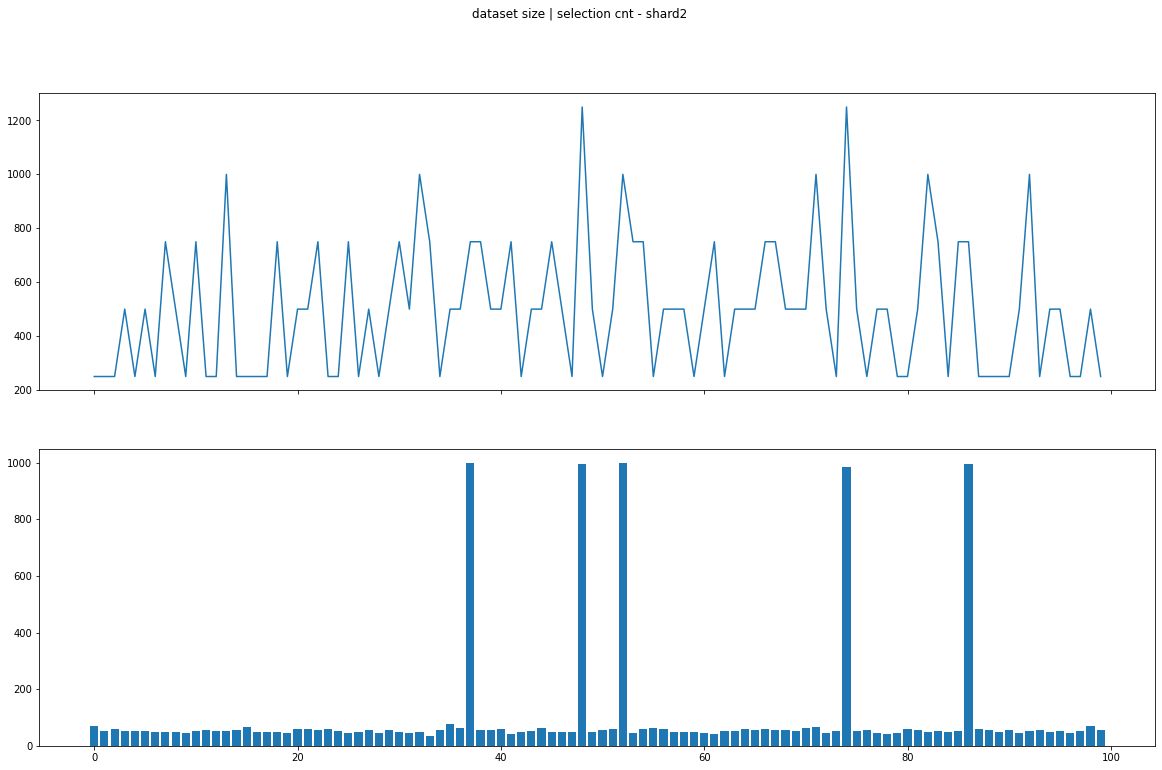

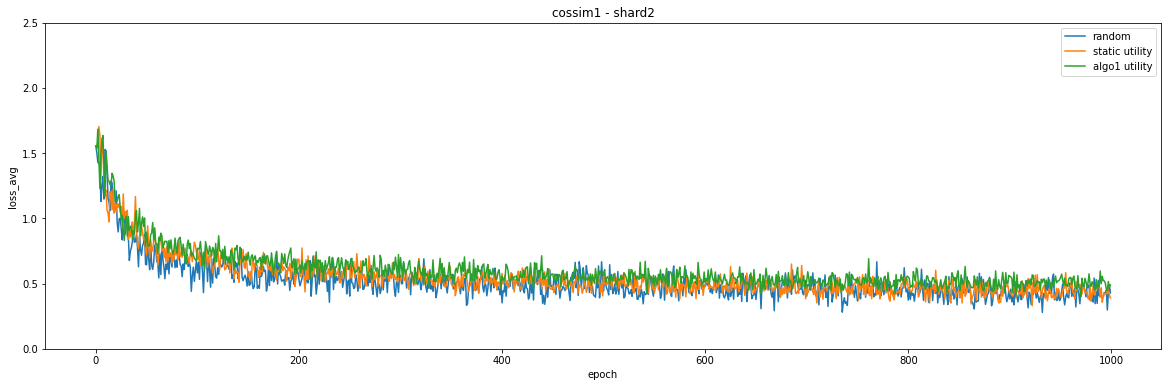

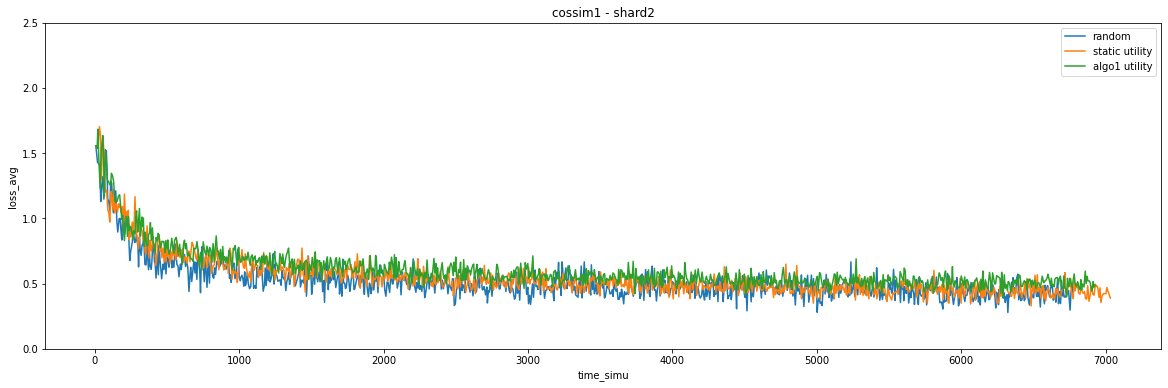

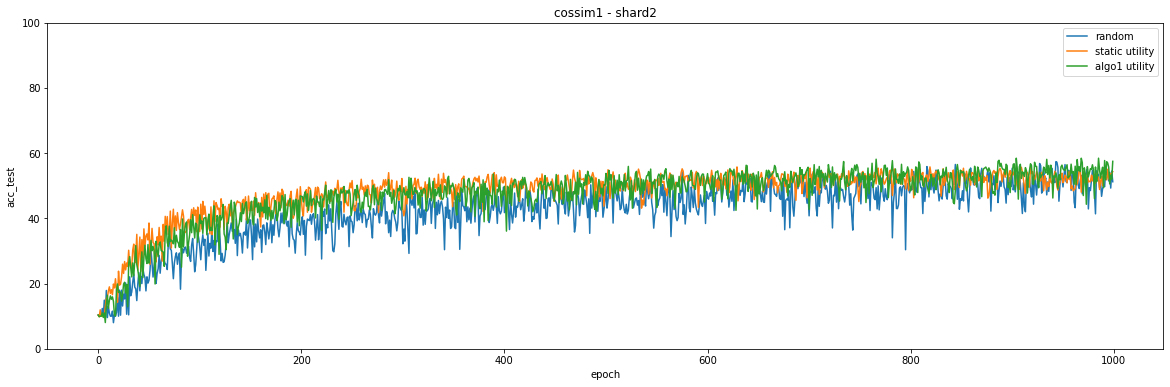

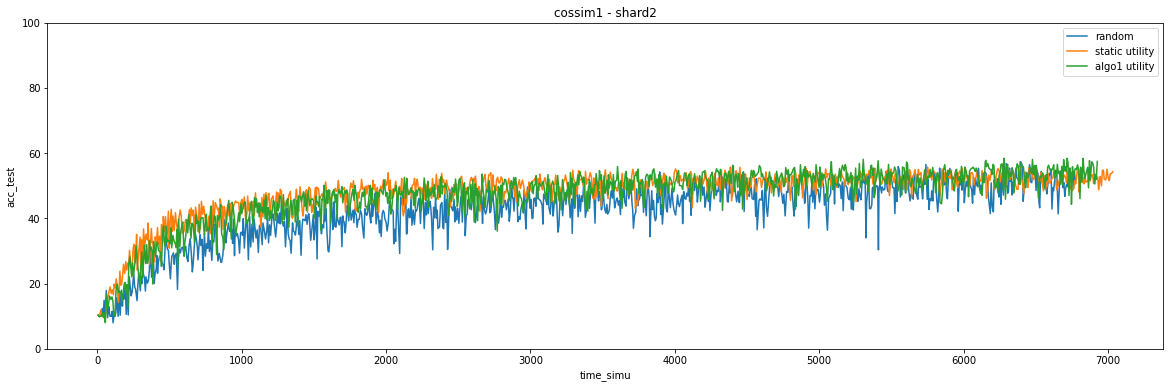

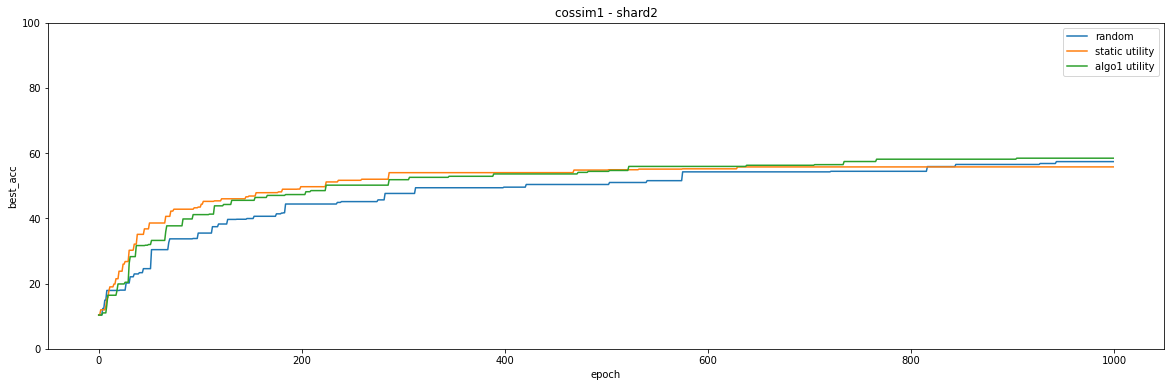

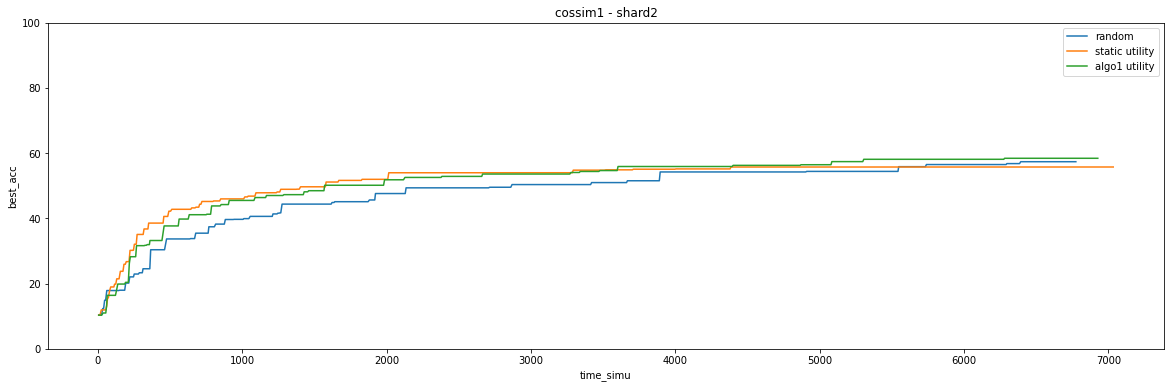

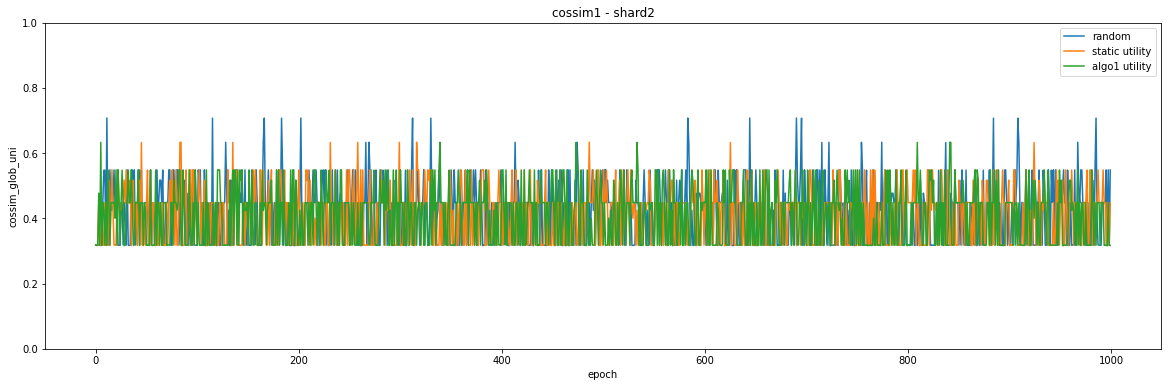

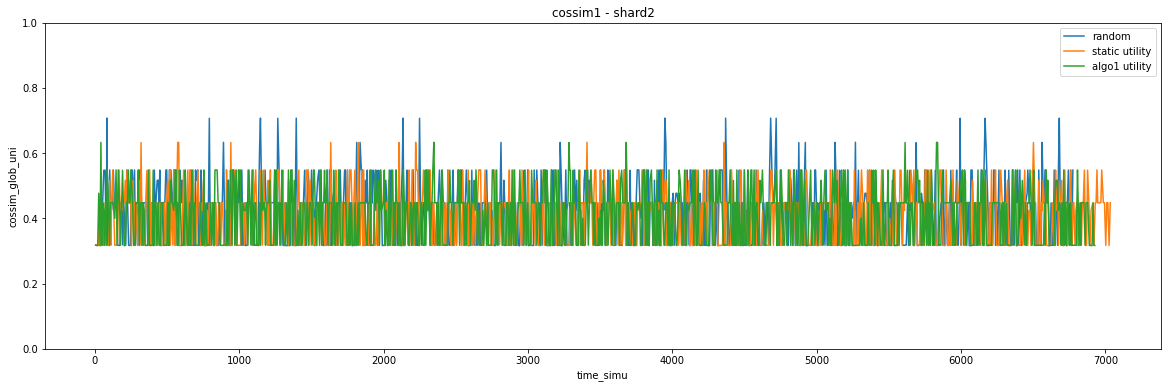

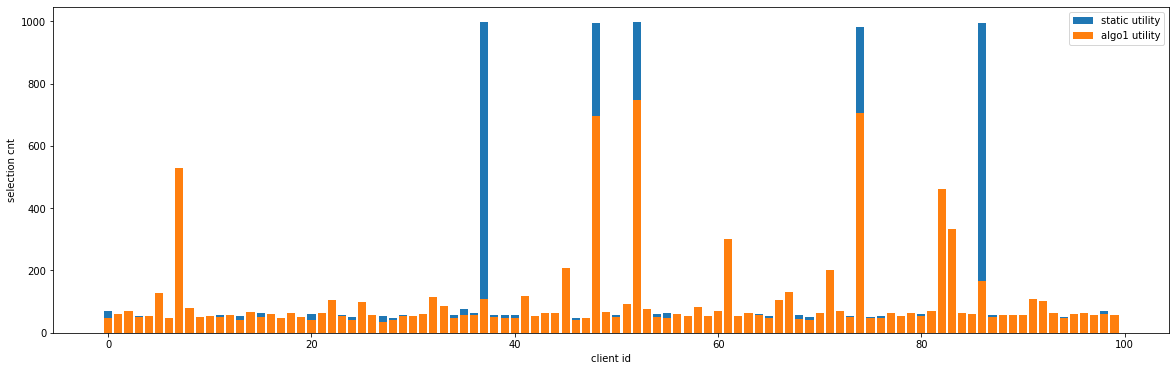

In [15]:
acc_fed = np.zeros(len(runs))
acc_utility = np.zeros(len(runs))
acc_local_localtest = np.zeros(len(runs))
acc_local_newtest_avg = np.zeros(len(runs))
acc_local_newtest_ens = np.zeros(len(runs))
lg_metrics = {}

fig, axs = plt.subplots(len(runs)+1, sharex=True, figsize=(20, 12))
fig.suptitle('dataset size | selection cnt - shard' + str(shard_per_user))
axs[0].plot(range(len(local_data_size)), local_data_size,label='local data size')

for idx, run in enumerate(runs):
    print('=== ', run, ' ===')
    # FedAvg
    base_dir_fed = os.path.join(base_dir, "{}/fedavg_cossim".format(run))
    if os.path.exists(base_dir_fed):
        results_path_fed = os.path.join(base_dir_fed, "results.csv")
        cossim_path_fed = os.path.join(base_dir_fed, "cossim_glob_uni.csv")
        cossim_glob_uni_fed = np.genfromtxt(cossim_path_fed, delimiter=',')
        
        df_fed = pd.read_csv(results_path_fed)
        df_fed['cossim_glob_uni'] = cossim_glob_uni_fed
        print(df_fed.head())
        df_fed = df_fed[:global_ep]
        print(df_fed.shape)
        acc_fed[idx] = df_fed.loc[df_fed.shape[0]-1]['best_acc']
        print('fedavg, best_acc', acc_fed[idx], '===================')
        print('')
    else:
        print('No random selection training result.')

    # fedavg w/ utility selection
    utility_algos = ['static', 'algo1']
    df_utility = {}
    slctcnt = {}
    base_dir_utility = {'static': os.path.join(base_dir, "{}/utility_cossim".format(run)),
                        'algo1': os.path.join(base_dir, "{}/algo1".format(run))}
    for algo in utility_algos:
        if os.path.exists(base_dir_utility[algo]):
            results_path_utility = os.path.join(base_dir_utility[algo], "results.csv")
            slctcnt_path = os.path.join(base_dir_utility[algo], "selection_cnt.csv")
            cossim_path_utility = os.path.join(base_dir_utility[algo], "cossim_glob_uni.csv")
            utility_path = os.path.join(base_dir_utility[algo], "utility.csv")
            df_utility[algo] = pd.read_csv(results_path_utility)
            slctcnt[algo] = np.genfromtxt(slctcnt_path, delimiter=',')
            cossim_glob_uni_utility = np.genfromtxt(cossim_path_utility, delimiter=',')
            df_utility[algo]['cossim_glob_uni'] = cossim_glob_uni_utility

            #utility = np.genfromtxt(utility_path, delimiter='\n')

            print(df_utility[algo].head())
            df_utility[algo] = df_utility[algo][:global_ep]
            print(df_utility[algo].shape)
            acc_utility[idx] = df_utility[algo].loc[df_utility[algo].shape[0]-1]['best_acc']
            print(algo,' utility selection, best_acc', acc_utility[idx], '===================')
            print('')
        else:
            print('No {} utility selection training result.'.format(algo))


    #['loss_avg', 'loss_test', 'acc_test', 'best_acc']
    plt.rcParams["figure.figsize"] = (20,6)
    metrics = [('loss_avg',[0, 2.5]), 
               ('acc_test', [0, 100]), 
               ('best_acc', [0, 100]),
               ('cossim_glob_uni', [0, 1])]
    
    for col, yl in metrics:
        for x in ['epoch', 'time_simu']:
            plt.figure()
            if os.path.exists(base_dir_fed):
                #plt.plot(df_fed[x], df_fed[col], label='random', marker='^')
                plt.plot(df_fed[x], df_fed[col], label='random')
            for algo in utility_algos:
                if os.path.exists(base_dir_utility[algo]):
                    #plt.plot(df_statsel[x], df_statsel[col], label='utility', marker='.')
                    plt.plot(df_utility[algo][x], df_utility[algo][col], label=algo + ' utility')
            plt.legend()
            plt.ylabel(col)
            plt.xlabel(x)
            plt.ylim(yl)
            plt.title(run + ' - shard' + str(shard_per_user))
            #plt.title(run + ' - ' + str(shard_per_user) + ' class per client')
    
    
    plt.figure()
    for algo in utility_algos:
        plt.bar(range(len(slctcnt[algo])), slctcnt[algo], label=algo + ' utility')
    plt.ylabel('selection cnt')
    plt.xlabel('client id')
    plt.legend()
    
    axs[idx+1].bar(range(len(slctcnt['static'])), slctcnt['static'])
    '''
    with open(utility_path) as fp_utility:
        plot_selection(fp_utility)
    '''


# final acc plot for multiple runs
'''    
plt.rcParams["figure.figsize"] = (20,6)
#plt.rcParams['font.size'] = 22
plt.figure()
plt.title('final acc')
plt.plot(range(len(acc_fed)), acc_fed, label='random')    
plt.plot(range(len(acc_utility)), acc_utility, label=algo + ' utility')
plt.xlabel('run')
plt.ylabel('acc')
plt.legend()
'''

[ 1.  2.  3.  5.  6.  5.  2.  4.  5.  8.  3.  5.  4.  4.  2.  2.  3.  4.
  5.  4.  2.  5.  2.  3.  6.  3.  6.  1.  7.  2.  3.  3.  3.  2.  4.  2.
  3.  3.  1.  1.  2.  4.  1.  1.  5.  1.  3.  2.  3.  5. 10.  4.  4.  3.
  2.  3.  4.  5.  3.  1.  1.  1.  4.  4.  4.  1.  5.  1.  3.  6.  4.  3.
  2.  1.  2.  3.  2.  2.  5.  2.  2.  5.  5.  5.  5.  5.  6.  2.  3.  4.
  6.  2.  2.  2.  6.  2.  6.  5.  7.  4.]


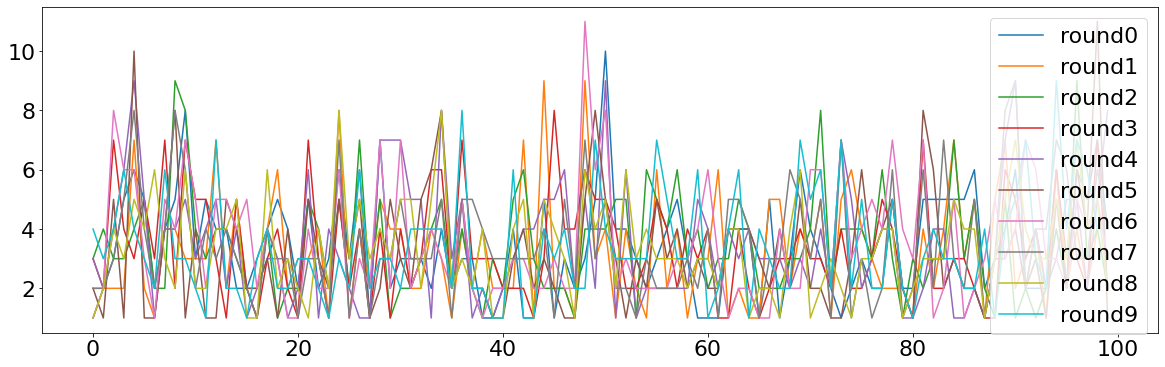

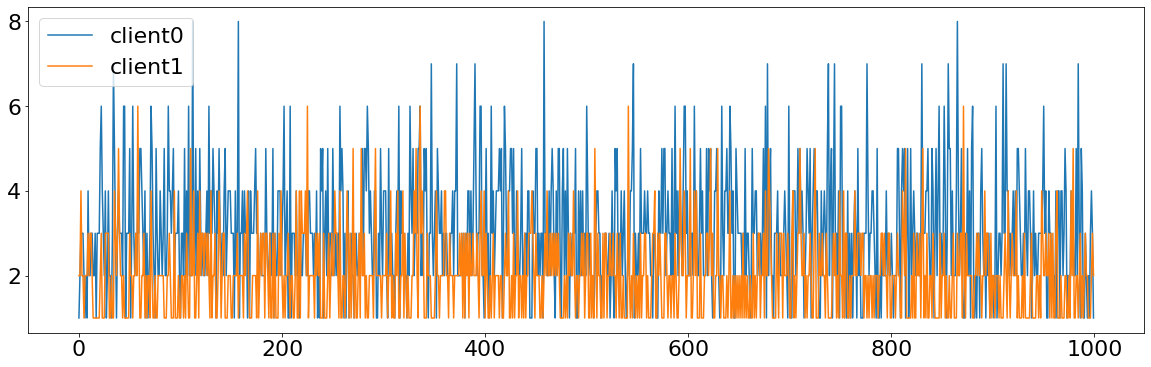

In [539]:
# plot t_i
ti_path = './save/user_config/var_time/{}_{}.csv'.format(dataset, num_users)
ti_all = np.genfromtxt(ti_path, delimiter=',')

plt.figure()
for ep in range(10):
    plt.plot(range(num_users), ti_all[:, ep], label='round'+str(ep))
    plt.legend()

print(ti_all[:,0])
plt.figure()
for user in range(2):
    plt.plot(range(global_ep), ti_all[user], label='client'+str(user))
    plt.legend()


In [428]:
columns = ["Run", "Local Test", "New Test (avg)", "New Test (ens)", "FedAvg Rounds", "LG Rounds"]
results = []

In [ ]:
str_acc_local_localtest = "{:.2f} +- {:.2f}".format(acc_local_localtest.mean(), acc_local_localtest.std())
str_acc_local_newtest_avg = "{:.2f} +- {:.2f}".format(acc_local_newtest_avg.mean(), acc_local_newtest_avg.std())
str_acc_local_newtest_ens = "{:.2f} +- {:.2f}".format(acc_local_newtest_ens.mean(), acc_local_newtest_ens.std())

print("localonly:\t", str_acc_local_localtest)
print("localonly_avg:\t", str_acc_local_newtest_avg)
print("localonly_ens:\t", str_acc_local_newtest_ens)

results.append(["LocalOnly", str_acc_local_localtest, str_acc_local_newtest_avg, str_acc_local_newtest_ens, 0, 0])

In [ ]:
for lg_run in sorted(lg_metrics.keys()):
    x = ["LG-FedAvg"]
    print(lg_run)
    for array in ['acc_local', 'acc_avg', 'acc_ens']:
        mean = lg_metrics[lg_run][array].mean()
        std = lg_metrics[lg_run][array].std()
        str_acc = "{:.2f} +- {:.2f}".format(mean, std)
        print("{}:\t{}".format(array, str_acc))
        
        x.append(str_acc)
    x.append(lg_run)
    x.append(rd_lg)
    results.append(x)

In [ ]:
str_acc_fed = "{:.2f} +- {:.2f}".format(acc_fed.mean(), acc_fed.std())
print("fed:\t", str_acc_fed)
results.append(["FedAvg", str_acc_fed, str_acc_fed, str_acc_fed, rd_fed, 0])

In [5]:
pd.DataFrame(results, columns=columns).set_index("Run")

NameError: name 'results' is not defined